In [3]:
import os
import cv2
import json
import joblib
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.applications import EfficientNetB3
from xgboost import XGBClassifier
import lightgbm as lgb
import catboost


Extracting from /kaggle/input/nexar-collision-prediction/train/:   0%|          | 0/1 [00:00<?, ?it/s]

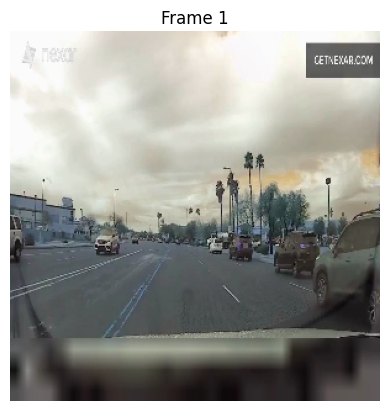

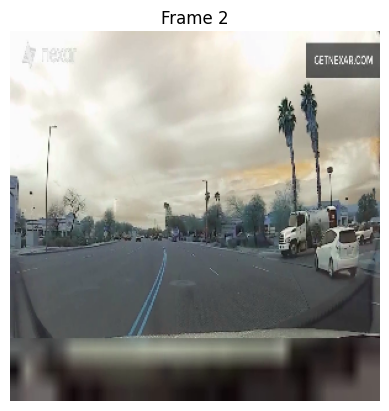

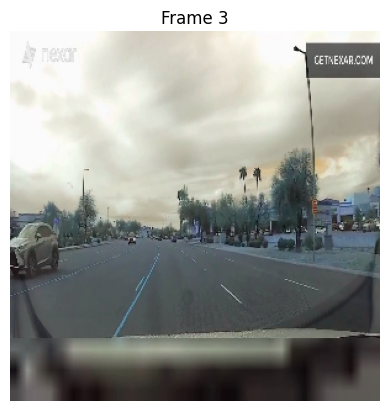

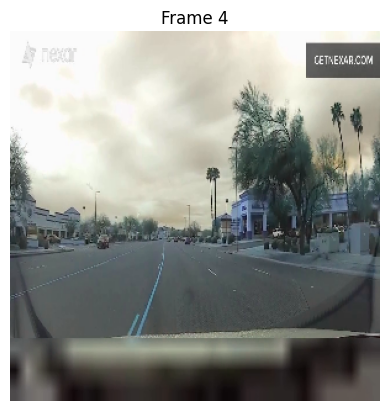

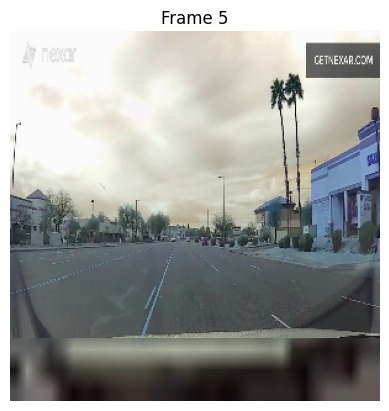

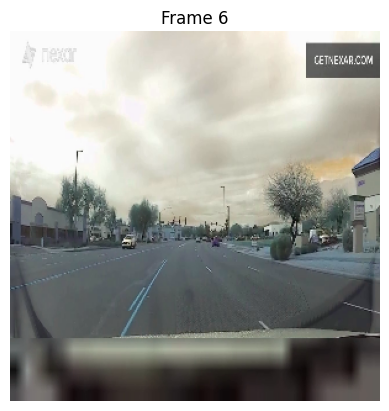

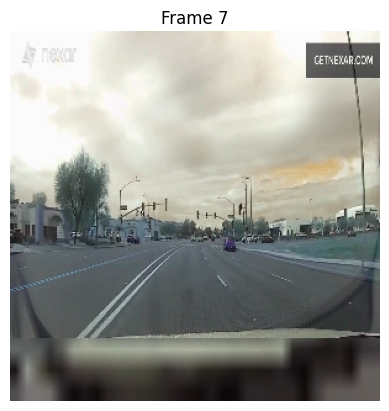

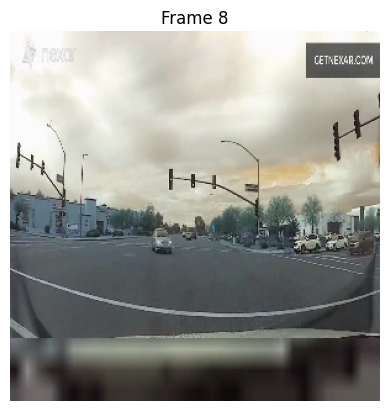

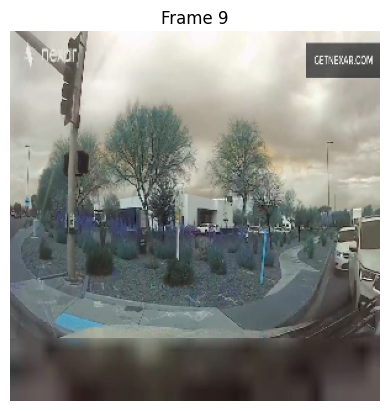

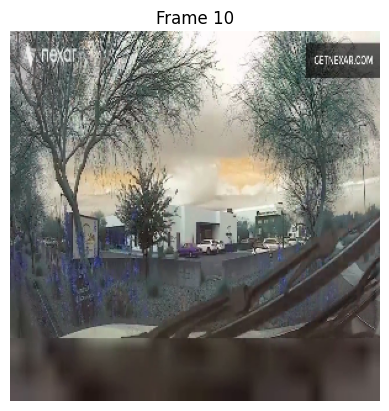

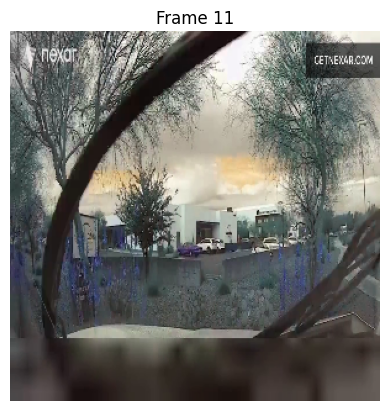

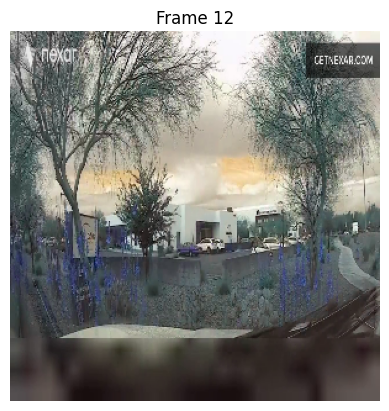

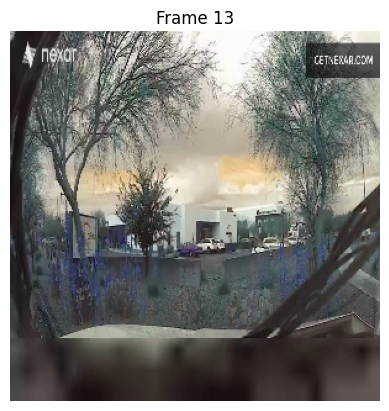

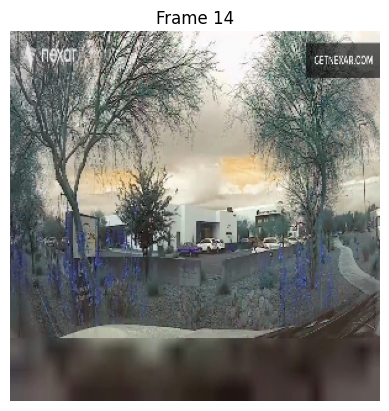

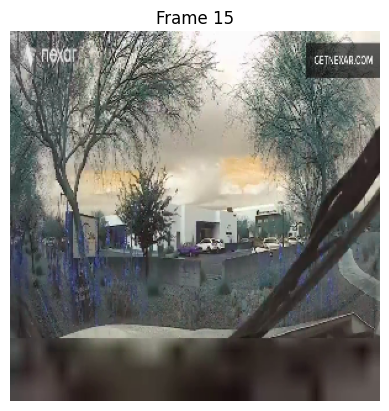

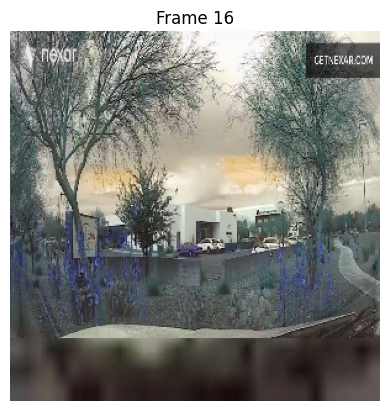

Extracting from /kaggle/input/nexar-collision-prediction/train/: 100%|██████████| 1/1 [00:15<00:00, 15.31s/it]

Extracted features shape for the video 00208: (1, 1536)


In [10]:
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.applications import EfficientNetB3
from tqdm import tqdm
import matplotlib.pyplot as plt

# 1. Load CSVs & pad IDs
df = pd.read_csv('/kaggle/input/nexar-collision-prediction/train.csv')
df_test = pd.read_csv('/kaggle/input/nexar-collision-prediction/test.csv')

# Pad IDs with leading zeros
df['id'] = df['id'].astype(str).str.zfill(5)
df_test['id'] = df_test['id'].astype(str).str.zfill(5)

# 2. Define video folder
train_dir = '/kaggle/input/nexar-collision-prediction/train/'

# 3. Frame sampling helper function with frame visualization
def extract_frames(path, num_frames=16, size=(300, 300), visualize=False):
    cap = cv2.VideoCapture(path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total <= 0:
        cap.release()
        return np.empty((0, *size, 3), dtype=np.uint8)
    
    step = max(total // num_frames, 1)
    frames = []
    
    for i in range(num_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, size)
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        # Visualize frame if required
        if visualize:
            plt.imshow(frame)
            plt.title(f"Frame {i+1}")
            plt.axis('off')
            plt.show()

    cap.release()
    return np.stack(frames) if frames else np.empty((0, *size, 3), dtype=np.uint8)

# 4. Load EfficientNetB3 model
base_model = EfficientNetB3(weights='imagenet', include_top=False, pooling='avg')
feat_dim = base_model.output_shape[-1]

# 5. Extract video features (For testing with one video)
def get_features(ids, folder, visualize=False):
    feats = []
    for vid in tqdm(ids, desc=f"Extracting from {folder}"):
        path = os.path.join(folder, f"{vid}.mp4")
        frames = extract_frames(path, visualize=visualize)
        if frames.size == 0:
            feats.append(np.zeros(feat_dim, dtype=np.float32))
            continue
        x = frames.astype('float32')  # EfficientNet expects inputs in [0, 255]
        f = base_model.predict(x, batch_size=16, verbose=0)
        feats.append(f.mean(axis=0))  # Aggregating feature across frames (mean)
    return np.vstack(feats)

# Now let's test it on just one video (use the first video from your training set for example)
test_video_id = df['id'].iloc[3]  # Take the first video from the training set
test_video_id = [test_video_id]   # Make it a list (you can add more video IDs here if needed)

# Extract features for the selected video and visualize frames
video_features = get_features(test_video_id, train_dir, visualize=True)

# Print out the shape of the extracted feature for the video
print(f"Extracted features shape for the video {test_video_id[0]}: {video_features.shape}")


In [ ]:
# 6. Extract features
X_train_full = get_features(df['id'], train_dir)
X_test = get_features(df_test['id'], test_dir)

# 7. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test)
y = df['target'].values

In [ ]:
# 8. Save preprocessed data
np.save("X_scaled.npy", X_scaled)
np.save("X_test_scaled.npy", X_test_scaled)
np.save("y.npy", y)

# Optionally also save the scaler if you'll apply it later
joblib.dump(scaler, "scaler.joblib")

print("✅ Saved X_scaled.npy, X_test_scaled.npy, y.npy, and scaler.joblib.")


In [11]:
X_scaled= np.load('/kaggle/input/full-data/X_scaled.npy')
X_test_scaled = np.load('/kaggle/input/full-data/X_test_scaled.npy')
y = np.load('/kaggle/input/full-data/y.npy')


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier


X_tr, X_val, y_tr, y_val = train_test_split(
    X_scaled, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 🌲 8. Train XGBoost classifier
clf = XGBClassifier(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    colsample_bytree= 0.7, 
    gamma= 0, 
    subsample= 0.7,
    random_state=42,
    eval_metric='logloss',
    
)

clf.fit(X_tr, y_tr)

# 📈 9. Validate
val_pred = clf.predict_proba(X_val)[:,1]
print("Validation ROC-AUC:", roc_auc_score(y_val, val_pred))

# 💾 10. Inference & submission
#X_test_scaled_sp = scaler.transform(X_test)
test_pred     = clf.predict_proba(X_test_scaled)[:,1]

submission = pd.DataFrame({
    'id':    df_test['id'],
    'score': test_pred
})
submission.to_csv('/kaggle/working/xgb_submissionbiist.csv', index=False)
print("✅ Written → xgb_submission.csv")

Validation ROC-AUC: 0.7245333333333333
✅ Written → xgb_submission.csv


In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
import numpy as np
import pandas as pd

# 📦 Setup
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# 🔁 Store out-of-fold predictions
oof_preds = np.zeros(X_scaled.shape[0])
test_preds = np.zeros(X_test_scaled.shape[0])

# 📊 Loop over folds
for fold, (train_idx, val_idx) in enumerate(skf.split(X_scaled, y)):
    print(f"\n🧪 Fold {fold + 1}/{n_splits}")
    
    X_tr, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]

    clf = XGBClassifier(
        n_estimators=1000,
        max_depth=6,
        learning_rate=0.01,
        use_label_encoder=False,
        colsample_bytree=0.7, 
        gamma=0, 
        subsample=0.7,
        random_state=42,
        eval_metric='logloss'
    )

    clf.fit(X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            verbose=100,  # prints every 100 rounds
            early_stopping_rounds=30)
    
    # Validation prediction
    val_pred = clf.predict_proba(X_val)[:, 1]
    oof_preds[val_idx] = val_pred
    score = roc_auc_score(y_val, val_pred)
    print(f"Fold {fold + 1} ROC-AUC: {score:.4f}")

    # Test prediction (average over folds)
    test_preds += clf.predict_proba(X_test_scaled)[:, 1] / n_splits

# 📈 Final OOF score
overall_score = roc_auc_score(y, oof_preds)
print(f"\n✅ Overall ROC-AUC: {overall_score:.4f}")

# 💾 Submission
submission = pd.DataFrame({
    'id': df_test['id'],
    'score': test_preds
})
submission.to_csv('/kaggle/working/xgb_submission_kfold.csv', index=False)
print("✅ Written → xgb_submission_kfold.csv")



🧪 Fold 1/5


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.69273
[100]	validation_0-logloss:0.66449
[111]	validation_0-logloss:0.66617
Fold 1 ROC-AUC: 0.6408

🧪 Fold 2/5


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.69152
[100]	validation_0-logloss:0.61490
[200]	validation_0-logloss:0.59936
[295]	validation_0-logloss:0.59599
Fold 2 ROC-AUC: 0.7456

🧪 Fold 3/5


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.69116
[100]	validation_0-logloss:0.61398
[200]	validation_0-logloss:0.59423
[300]	validation_0-logloss:0.58914
[350]	validation_0-logloss:0.58953
Fold 3 ROC-AUC: 0.7564

🧪 Fold 4/5


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.69131
[100]	validation_0-logloss:0.59137
[200]	validation_0-logloss:0.55301
[300]	validation_0-logloss:0.54188
[400]	validation_0-logloss:0.53726
[450]	validation_0-logloss:0.53649
Fold 4 ROC-AUC: 0.8080

🧪 Fold 5/5


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.69118
[100]	validation_0-logloss:0.60917
[200]	validation_0-logloss:0.58474
[300]	validation_0-logloss:0.57904
[301]	validation_0-logloss:0.57907
Fold 5 ROC-AUC: 0.7697

✅ Overall ROC-AUC: 0.7506
✅ Written → xgb_submission_kfold.csv


In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# 📦 Setup
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# 🔁 Store OOF predictions
oof_preds = np.zeros(X_scaled.shape[0])
test_preds = np.zeros(X_test_scaled.shape[0])

# ⏳ Reshape input for LSTM: (samples, timesteps=1, features)
X_scaled_seq = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
X_test_seq = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# 📊 Loop over folds
for fold, (train_idx, val_idx) in enumerate(skf.split(X_scaled, y)):
    print(f"\n🧪 Fold {fold + 1}/{n_splits}")
    
    X_tr_seq, X_val_seq = X_scaled_seq[train_idx], X_scaled_seq[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]

    # Define model
    model = Sequential([
        Masking(mask_value=0., input_shape=(1, X_scaled.shape[1])),
        LSTM(128, dropout=0.2, recurrent_dropout=0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['AUC'])

    # Train
    model.fit(
        X_tr_seq, y_tr,
        validation_data=(X_val_seq, y_val),
        epochs=20,
        batch_size=64,
        callbacks=[EarlyStopping(monitor='val_auc', mode='max', patience=3, restore_best_weights=True)],
        verbose=1
    )

    # Validation prediction
    val_pred = model.predict(X_val_seq).ravel()
    oof_preds[val_idx] = val_pred
    score = roc_auc_score(y_val, val_pred)
    print(f"📈 Fold {fold + 1} ROC-AUC: {score:.4f}")

    # Test prediction
    test_pred = model.predict(X_test_seq).ravel()
    test_preds += test_pred / n_splits

# 📈 Final OOF score
overall_score = roc_auc_score(y, oof_preds)
print(f"\n✅ Overall ROC-AUC: {overall_score:.4f}")

# 💾 Submission
submission = pd.DataFrame({
    'id': df_test['id'],
    'score': test_preds
})
submission.to_csv('/kaggle/working/lstm_submission_kfold.csv', index=False)
print("✅ Written → lstm_submission_kfold.csv")



🧪 Fold 1/5
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3553: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 0.6739 - loss: 0.6401 - val_AUC: 0.6384 - val_loss: 0.7313
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.8661 - loss: 0.4682 - val_AUC: 0.6456 - val_loss: 0.7175
Epoch 3/20
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - AUC: 0.9218 - loss: 0.3874

/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:360: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,loss,val_AUC,val_loss
  callbacks.on_epoch_end(epoch, epoch_logs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9356 - loss: 0.3753 - val_AUC: 0.6557 - val_loss: 0.7376
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9639 - loss: 0.3093 - val_AUC: 0.6470 - val_loss: 0.7813
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9851 - loss: 0.2340 - val_AUC: 0.6501 - val_loss: 0.7964
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9950 - loss: 0.1867 - val_AUC: 0.6489 - val_loss: 0.8523
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9979 - loss: 0.1492 - val_AUC: 0.6508 - val_loss: 0.8660
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9997 - loss: 0.1033 - val_AUC: 0.6514 - val_loss: 0.9057
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9999 - loss: 0.0812 - val_AUC: 0.6526 - val_loss: 0.9544
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 1.0000 - loss: 0.0634 - val_AUC: 0.6455 - val_loss: 0.9876
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 1.0000 - loss: 0.0492 - 

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3553: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - AUC: 0.6831 - loss: 0.6443 - val_AUC: 0.7378 - val_loss: 0.6059
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.8569 - loss: 0.4892 - val_AUC: 0.7448 - val_loss: 0.6051
Epoch 3/20
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - AUC: 0.8988 - loss: 0.4241

/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:360: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,loss,val_AUC,val_loss
  callbacks.on_epoch_end(epoch, epoch_logs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9215 - loss: 0.4025 - val_AUC: 0.7310 - val_loss: 0.6213
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9724 - loss: 0.2978 - val_AUC: 0.7141 - val_loss: 0.6578
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9882 - loss: 0.2586 - val_AUC: 0.7298 - val_loss: 0.6606
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9945 - loss: 0.2013 - val_AUC: 0.7205 - val_loss: 0.6915
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9978 - loss: 0.1563 - val_AUC: 0.7117 - val_loss: 0.7037
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9997 - loss: 0.1237 - val_AUC: 0.7231 - val_loss: 0.7519
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 1.0000 - loss: 0.0881 - val_AUC: 0.7074 - val_loss: 0.7651
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 1.0000 - loss: 0.0688 - val_AUC: 0.7120 - val_loss: 0.7949
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 1.0000 - loss: 0.0553 - 

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3553: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 0.6855 - loss: 0.6422 - val_AUC: 0.7530 - val_loss: 0.5963
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.8501 - loss: 0.4955 - val_AUC: 0.7567 - val_loss: 0.5896
Epoch 3/20
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - AUC: 0.9147 - loss: 0.4093

/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:360: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,loss,val_AUC,val_loss
  callbacks.on_epoch_end(epoch, epoch_logs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9253 - loss: 0.4026 - val_AUC: 0.7546 - val_loss: 0.6022
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9600 - loss: 0.3262 - val_AUC: 0.7478 - val_loss: 0.6083
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9844 - loss: 0.2630 - val_AUC: 0.7588 - val_loss: 0.6163
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9911 - loss: 0.2107 - val_AUC: 0.7403 - val_loss: 0.6536
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9963 - loss: 0.1662 - val_AUC: 0.7497 - val_loss: 0.6408
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9996 - loss: 0.1148 - val_AUC: 0.7517 - val_loss: 0.6760
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9995 - loss: 0.1021 - val_AUC: 0.7476 - val_loss: 0.6857
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9999 - loss: 0.0816 - val_AUC: 0.7522 - val_loss: 0.7092
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 1.0000 - loss: 0.0626 - 

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3553: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - AUC: 0.6475 - loss: 0.6591 - val_AUC: 0.7957 - val_loss: 0.5471
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.8557 - loss: 0.4867 - val_AUC: 0.7968 - val_loss: 0.5533
Epoch 3/20
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - AUC: 0.9667 - loss: 0.4015

/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:360: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,loss,val_AUC,val_loss
  callbacks.on_epoch_end(epoch, epoch_logs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9359 - loss: 0.4002 - val_AUC: 0.7981 - val_loss: 0.5452
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9716 - loss: 0.3134 - val_AUC: 0.8008 - val_loss: 0.5494
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9820 - loss: 0.2633 - val_AUC: 0.7965 - val_loss: 0.5692
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9936 - loss: 0.2086 - val_AUC: 0.7888 - val_loss: 0.5785
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9975 - loss: 0.1629 - val_AUC: 0.7844 - val_loss: 0.6094
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9987 - loss: 0.1252 - val_AUC: 0.7850 - val_loss: 0.6275
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9999 - loss: 0.0922 - val_AUC: 0.7752 - val_loss: 0.6420
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 1.0000 - loss: 0.0757 - val_AUC: 0.7829 - val_loss: 0.6717
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 1.0000 - loss: 0.0567 - 

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3553: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - AUC: 0.6638 - loss: 0.6533 - val_AUC: 0.7559 - val_loss: 0.5939
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.8626 - loss: 0.4778 - val_AUC: 0.7614 - val_loss: 0.5855
Epoch 3/20
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - AUC: 0.9653 - loss: 0.3476

/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:360: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,loss,val_AUC,val_loss
  callbacks.on_epoch_end(epoch, epoch_logs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9326 - loss: 0.4050 - val_AUC: 0.7609 - val_loss: 0.5884
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9569 - loss: 0.3316 - val_AUC: 0.7544 - val_loss: 0.6020
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9876 - loss: 0.2634 - val_AUC: 0.7542 - val_loss: 0.6161
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9910 - loss: 0.2161 - val_AUC: 0.7539 - val_loss: 0.6367
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9956 - loss: 0.1675 - val_AUC: 0.7535 - val_loss: 0.6368
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9994 - loss: 0.1263 - val_AUC: 0.7502 - val_loss: 0.6688
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9998 - loss: 0.0990 - val_AUC: 0.7562 - val_loss: 0.6846
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 1.0000 - loss: 0.0771 - val_AUC: 0.7452 - val_loss: 0.7008
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 1.0000 - loss: 0.0643 - 

In [1]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, plot_importance

# 🔢 1. Train-test split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_scaled, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)
# Use different classifiers as base models
base_learners = [
    ('xgb', XGBClassifier(n_estimators=1000, max_depth=6, learning_rate=0.1, eval_metric='logloss')),
    ('catboost', CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.1, loss_function='Logloss')),
    ('lgbm', LGBMClassifier(n_estimators=1000, max_depth=6, learning_rate=0.1, verbosity=-1))
]

# Meta model
meta_model = LogisticRegression()

# Stacking model
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_model)

stacking_model.fit(X_tr, y_tr)
val_pred = stacking_model.predict_proba(X_val)[:, 1]
print("Stacking Model ROC-AUC:", roc_auc_score(y_val, val_pred))


KeyboardInterrupt: 